# RESUME ANALYSER

### Importing required packages and libraries

In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
nlp=spacy.load("en_core_web_sm")

import unicodedata

from wordcloud import WordCloud as wordcloud

import docx2txt

### model libraries imported

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack


### Resume dataset uploaded

In [3]:
df=pd.read_csv("ResumeDataSet.csv")

### Resume dataset analysis

#### Unique categories in the dataset

In [4]:
df.Category.unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

#### Enteries correspoding to unique categories 

In [5]:
df.Category.value_counts().head(10)

Java Developer         84
Testing                70
DevOps Engineer        55
Python Developer       48
Web Designing          45
HR                     44
Hadoop                 42
Operations Manager     40
Mechanical Engineer    40
ETL Developer          40
Name: Category, dtype: int64

#### Plotting the categories for visual depiction

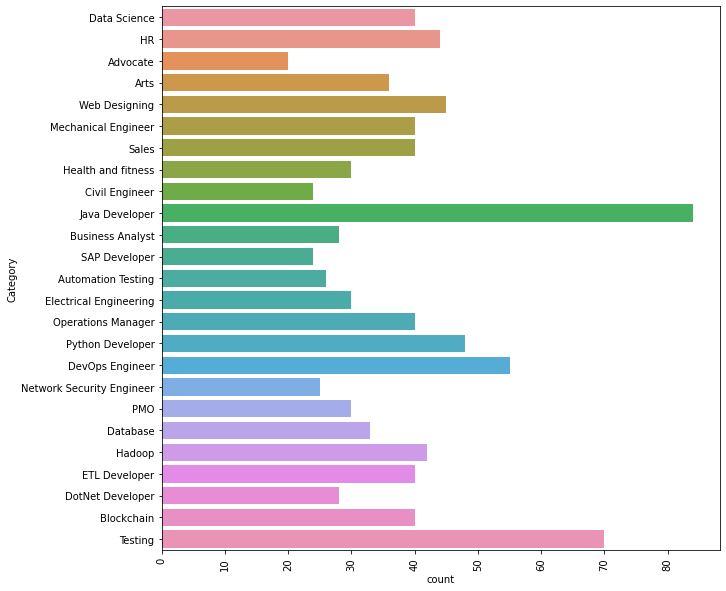

In [6]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=df)
plt.show()

#### We can easily show, Java Developers have the most resumes in the dataset

### Creating functions to edit the content column

#### Function to removed Accented chracters in the input string

In [7]:
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

#### Function to remove- URL/Website/email/hashtag/mention/special-char/stop-words and lowercasing the output

In [8]:
def funt(x):
    x= re.sub(" \d+"," ",x)
    x= re.sub("http\S+\s*"," ", x)##url removal
    x= re.sub("[a-zA-Z.-_]+[a-zA-Z.-_]+\.[a-zA-Z.-_]+"," ",x)## website removal
    x= re.sub("[a-zA-Z.-_]+@[a-zA-Z.-_]+\.[a-zA-Z.-_]+"," ",x) ##email removal
    x= re.sub("#\S+"," ",x)### hastage removal
    x= re.sub("@\S+"," ",x)###mention removal
    x=" ".join([t for t in x.split() if t not in "!@#$:%^&-_*(),."])## special character remobal
    x=x.lower()
    x=re.sub("\s+"," ",x)
    x=" ".join([t for t in x.split() if t not in stopwords])
    return x

#### handeling contractions and converting to expansions

In [9]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

In [10]:
## Function to convert contractions to expansions in the input string

def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x
    

#### Function to Check values on character level and print only non special characters

In [11]:
def splitter(x):
    val=[]
    for words in x.split():
        ch= [char for char in words if char not in ".,()/1234+%56';\"7890:{}-_!"]
        w="".join(ch)
        val.append(w)
    return " ".join(val)

#### Function to convert words into lemma forms

In [12]:

def lemmer(ent):
    val=[]
    doc=nlp(ent)
    for token in doc:
        word=token.lemma_
        val.append(word)
    return " ".join(val)


### Executing the functions on the content columns

In [13]:
df["clean"]=df["Resume"].apply(lambda x : remove_accented_chars(x))

In [14]:
df["clean"]=df["clean"].apply(lambda x: cont_to_exp(x))

In [15]:
df["clean"]=df["clean"].apply(lambda x: funt(x))

In [16]:
text_c=" ".join(df["clean"])

## Finding common and rare words in the total text in the content column

In [17]:
text=splitter(text_c)

### Finding common words and their occurance frequency

#### Common words

In [18]:
pd.Series(text.split()).value_counts()[:11]

exprience      3829
company        3522
project        3361
months         3283
description    3122
details        3096
data           2133
management     1969
team           1918
maharashtra    1449
system         1395
dtype: int64

#### Rare words

In [19]:
pd.Series(text.split()).value_counts()[-11:]

cru          1
vqi          1
tulu         1
apple        1
nunit        1
tail         1
tdm          1
tfs          1
poland       1
xslt         1
exercises    1
dtype: int64

### Dropping Resume column, as we have now a clean column

In [20]:
df.drop(["Resume"], axis=1,inplace=True)

In [21]:
df.head()

,Category,clean
0,Data Science,"skills programming languages: python (pandas, ..."
1,Data Science,education details b.e uit-rgpv data scientist ...
2,Data Science,"areas interest deep learning, control system d..."
3,Data Science,skills r python sap hana tableau sap hana sql ...
4,Data Science,"education details mca ymcaust, faridabad, hary..."


## Word Cloud creation

#### Word clouds are great way of depicting the common and rare words

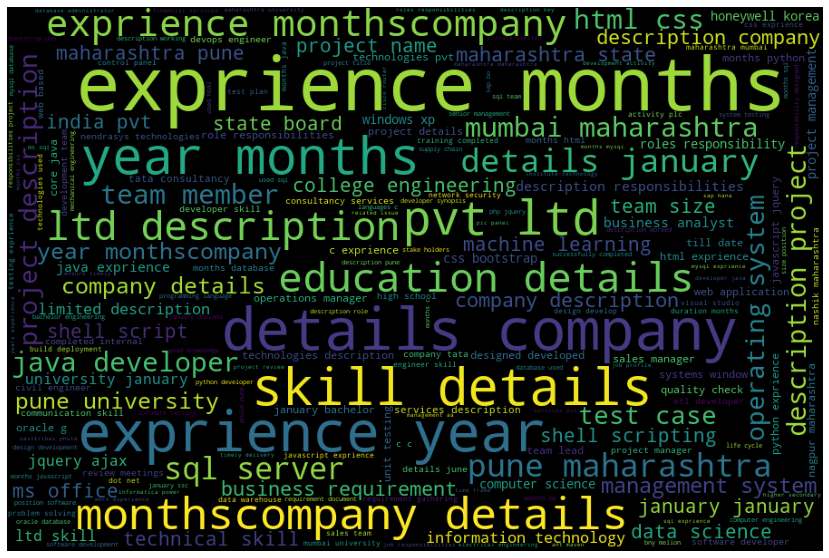

In [22]:
plt.figure(figsize=(15,10))
wc = wordcloud(width=900, height=600).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.show()

### Converting the category column in numerical form

In [23]:
var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

#### creating a copy of the dataset for further operations

In [24]:
dd=df.copy()

## Proceeding with word to TFIDF conversion/data to train and test conversion

In [25]:
requiredText = dd['clean'].values
requiredTarget = dd['Category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("FEATURES CONVERTED")
print(" ")
print( "Shape of xtrain and xtest below: ")
X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

FEATURES CONVERTED
 
Shape of xtrain and xtest below: 
(769, 1500)
(193, 1500)


## KNeighborClassification model creation

### Printing Accuracy and Classification report

In [26]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99

 Classification report for classifier KNeighborsClassifier():
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         9
          14      

## Model has a high accuracy for all the categories

### Testing the accuracy through a real life resume(my own resume)

#### Reading my own resume-Daman_resume.docx

In [27]:

my_text=docx2txt.process("/home/demon/Documents/projects/Resume_scanner/Daman_resume.docx")

#### Creating a plain text file-Output from the rich-text docx file

In [28]:
# creating Output file() richtext in resume as plain text)
with open("Output.txt", "w") as text_file:

    print(my_text, file=text_file)

#### Reading the plain text-Output.txt

In [29]:
## reading the text file
with open("Output.txt","r+") as file:
    file_text=file.read()

In [30]:
## removing accented characters using the remove_accented_chars function created above
file_text=remove_accented_chars(file_text)

In [31]:
##removing \n#
file_text=re.sub("\n"," ", file_text)

In [32]:
## applying funt function
file_text=funt(file_text)

In [33]:
## character wise checking
file_text=splitter(file_text)

In [34]:
##lementsation(optional, as we didnt do it in the begining)
file_text=lemmer(file_text)

In [35]:
### taking copy 
testy=file_text


#### Using transform method on the tfidfvecorizer model we created

In [36]:
final=word_vectorizer.transform([testy])

In [37]:
final.shape

(1, 1500)

### Predicting from the resume

In [38]:
clf.predict(final)

array([6])

## prediction successful !!!
## The output above: 6 represenents DATA SCIENCE

#### Will create a web app in future for this, till then enjoy !!